In [1]:
import influxdb
from statistics import stdev, mean, median
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import lmfit 
from scipy.stats import randint
from cf_matrix import *

from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction.settings import TimeBasedFCParameters
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
import influx_secrets as infsec

In [2]:
HOST = infsec.host
PORT = infsec.port
USERNAME = infsec.user
PASSWORD = infsec.pwd
DATABASE = infsec.db

client = influxdb.InfluxDBClient(HOST, PORT, USERNAME, PASSWORD, DATABASE, ssl=True, verify_ssl=True)

device_locations = infsec.dev_locs
device_ids = infsec.dev_ids

In [3]:
def exponential_function(x, a, b, c):
    return a * np.exp(-b * x) + c

def f1(x, a0, a1, a2, a3):
    #https://stackoverflow.com/questions/34471006/how-to-determine-function-or-curve-fit-unknown-function-with-python
    return a0 + a1/x + a2/x**2 + a3/x**3

def f2(x, a0, a1, a2, a3):
    #https://stackoverflow.com/questions/34471006/how-to-determine-function-or-curve-fit-unknown-function-with-python
    return a0 + a1*x + a2*x**2 + a3*x**3

def logistic_function(x, x_0, L, k):
    #https://www.architecture-performance.fr/ap_blog/fitting-a-logistic-curve-to-time-series-in-python/
    return L/(1+np.exp(-k*(x-x_0)))    

In [4]:
def pull_awair_voc_data(start_time, end_time, device_id):
    '''
    This program checks to see if there are any VOC spikes by an inputted sensor

    TODO
    '''
    #Gets the value for the sensor that works
    result = client.query("SELECT MEAN(value) FROM voc_ppb WHERE (device_id = \'" + device_id + "\') and time > " + start_time + " and time < " + end_time + " GROUP BY location_specific, time(10s) fill(null)")
    score_list = []
    #For each element in the VOC data, grab the score and time. Within the score and time, grab just the score (aka the mean)
    for element in result.items():
                score_and_time = list(element[1])
                for item in score_and_time:
                    score_list.append(item['mean'])
    return score_list

In [ ]:
def pull_new_voc_data(start_time, end_time):
    '''
    TODO
    '''
    #Pull all data for each individual sensor for a selected timeframe
    sensirion_result = client.query("SELECT mean(value) FROM voc_index WHERE (sensors = \'Sensirion_SEN54\') AND time > " + start_time + " and time < " + end_time + " GROUP BY time(10s) fill(null)")
    ec_result = client.query("SELECT mean(value) FROM voc_ppb WHERE (sensor = \'EC_Sense_PS1_VOC\') AND time > " + start_time + " and time < " + end_time + " GROUP BY time(10s) fill(null)")
    unnamed_result = client.query("SELECT mean(value) FROM voc_ppm WHERE (sensor = \'Unnamed_gas_sensor\') AND time > " + start_time + " and time < " + end_time + " GROUP BY time(10s) fill(null)")
    seeed_result = client.query("SELECT mean(value) FROM voc_ppm WHERE (sensor = \'Seeed_Grove_HCHO_sensor\') AND time > " + start_time + " and time < " + end_time + " GROUP BY time(10s) fill(null)")

    #For each (label, result) pair, get the score list and return a dictionary 'score_dict' with all data for each sensor
    score_dict = {}
    for result in [("Sensirion_SEN54",sensirion_result), ("EC_Sense_PS1_VOC",ec_result), ("Unnamed_gas_sensor", unnamed_result), ("Seeed_Grove_HCHO_sensor",seeed_result)]:
        score_list = []
        for element in result[1].items():
            score_and_time = list(element[1])
            for item in score_and_time:
                #Do value adjustments for data
                if (item['mean'] != None) and result[0] == 'EC_Sense_PS1_VOC':
                    if item['mean'] < 5000:
                        score_list.append(item['mean'])
                    else:
                        score_list.append(np.NaN)
                elif (item['mean'] != None) and result[0] in ['Unnamed_gas_sensor','Seeed_Grove_HCHO_sensor']:
                    if item['mean']*1000 < 5000:
                        score_list.append(item['mean'] * 1000)
                    else:
                        score_list.append(np.NaN)  
                else:
                    score_list.append(item['mean'])
        score_dict[result[0]] = score_list
    return score_dict

In [5]:
def format_time_string(time_string):
    '''
    TODO
    '''
    split_spaces = time_string.split(" ")
    mm_dd_yy = split_spaces[0].split("/")
    return_string = "\'" + mm_dd_yy[2] + "-" + mm_dd_yy[0] + "-" + mm_dd_yy[1] + "T" + split_spaces[1] + ".00000000Z\'"
    return return_string

In [6]:
# if __name__ == '__main__':
complete_df = pd.DataFrame(columns=['id', 'time', 'value'])
complete_y = pd.Series()

df = pd.read_csv('./data/citral-dlim79.csv', sep=',', header=0)
chem_dos_id = 0

In [7]:
for chemical in df["Chemical"].unique():
    chemical_df = df[df['Chemical'] == chemical]
    for dosage in chemical_df['Dosage'].unique():
        chem_dos_df = chemical_df[chemical_df['Dosage'] == dosage]
        #Pull out the values for each row
        for index, row in chem_dos_df.iterrows():
            #Use the Start Time and End Time to Query influx DB
            #Pull Awair Data and Store into pandas dataframe
            awair_voc_data_1 = pull_awair_voc_data(format_time_string(row["Start Time UTC"]), format_time_string(row["End Time UTC"]), device_ids[2])
            awair_voc_data_2 = pull_awair_voc_data(format_time_string(row["Start Time UTC"]), format_time_string(row["End Time UTC"]), device_ids[0])
            awair_voc_data_3 = pull_awair_voc_data(format_time_string(row["Start Time UTC"]), format_time_string(row["End Time UTC"]), device_ids[1])
            awair_voc_data_4 = pull_awair_voc_data(format_time_string(row["Start Time UTC"]), format_time_string(row["End Time UTC"]), device_ids[3])
            awair_data = {"AWAIR_SENSOR_1": awair_voc_data_1, "AWAIR_SENSOR_2" : awair_voc_data_2, "AWAIR_SENSOR_3" : awair_voc_data_3, "AWAIR_SENSOR_4" : awair_voc_data_4}
            room_voc_df = pd.DataFrame(awair_data)
            #Find Median and Mean and store in pandas dataframe
            awair_mean = room_voc_df.mean(axis=1)
            awair_median = room_voc_df.median(axis=1)
            room_voc_df["AWAIR_MEAN"] = awair_mean
            room_voc_df["AWAIR_MEDIAN"] = awair_median
            time_1_second = list(range(len(awair_mean)))
            time_10_second = [i * 10 for i in time_1_second]
            room_voc_df['time'] = time_10_second
            for awair_sensor in ["AWAIR_SENSOR_1", "AWAIR_SENSOR_2", "AWAIR_SENSOR_3", "AWAIR_SENSOR_4"]:
                room_voc_df['id'] = chem_dos_id
                room_voc_df['value'] = room_voc_df[awair_sensor]
                room_voc_df.dropna(inplace=True)
                y = pd.Series([chemical+dosage], index=[chem_dos_id])
                #Add the values in the correct format to the complete df dataset
                complete_df = pd.concat([complete_df, room_voc_df], join="inner")
                #Add the labels to the y dataset
                complete_y = pd.concat([complete_y, y])
                # print(complete_df)
                # print(complete_y)
                chem_dos_id+=1

In [8]:
extraction_settings = ComprehensiveFCParameters()
time_settings = TimeBasedFCParameters()
custom_settings = {
    "autocorrelation": [{"lag":1},{"lag":3},{"lag":5},{"lag":8}],
    "approximate_entropy": [{"m":2, "r":0.7}],
    "sample_entropy": None,
    "lempel_ziv_complexity":[{"bins":2},{"bins":3}],
    "permutation_entropy": [{"tau":1, "dimension":3},{"tau":1, "dimension":4}],
    "longest_strike_above_mean" : None,
    }

In [9]:
X = extract_features(complete_df, column_id="id", column_sort="time", default_fc_parameters=extraction_settings, column_kind=None, column_value=None)
impute(X)
#X_filtered = select_features(X, complete_y)

Feature Extraction: 100%|██████████| 39/39 [00:03<00:00, 10.70it/s]
/u/gyx4bw/.local/lib/python3.10/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['value__fft_coefficient__attr_"real"__coeff_46'
 'value__fft_coefficient__attr_"real"__coeff_47'
 'value__fft_coefficient__attr_"real"__coeff_48'
 'value__fft_coefficient__attr_"real"__coeff_49'
 'value__fft_coefficient__attr_"real"__coeff_50'
 'value__fft_coefficient__attr_"real"__coeff_51'
 'value__fft_coefficient__attr_"real"__coeff_52'
 'value__fft_coefficient__attr_"real"__coeff_53'
 'value__fft_coefficient__attr_"real"__coeff_54'
 'value__fft_coefficient__attr_"real"__coeff_55'
 'value__fft_coefficient__attr_"real"__coeff_56'
 'value__fft_coefficient__attr_"real"__coeff_57'
 'value__fft_coefficient__attr_"real"__coeff_58'
 'value__fft_coefficient__attr_"real"__coeff_59'
 'value__fft_coefficient__attr_"real"__coeff_60'
 'value__fft_coefficient__attr_"real"__coeff_61'
 'value__fft_coefficient__at

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,1.0,9855.0,1153487.0,7.988095,0.369048,-0.018072,117.0,...,0.573901,1.147388,2.862133,1.705297,2.972247,4.049889,4.330041,4.369448,0.0,134.142857
1,1.0,0.0,0.0,1.0,4554.0,1683240.0,32.345238,0.107143,0.066265,40.0,...,0.220352,0.469942,2.354319,1.764352,3.035826,3.886277,4.278055,4.334352,0.0,218.571429
2,1.0,0.0,0.0,1.0,6992.0,587854.0,8.202381,0.440476,-0.066265,84.0,...,0.220352,0.406195,2.186873,1.777101,3.017231,4.022120,4.312712,4.369448,0.0,100.428571
3,1.0,1.0,0.0,1.0,3618.0,160856.0,3.750000,0.273810,-0.078313,45.0,...,0.220352,0.329684,1.820093,1.732116,2.995279,3.904247,4.236857,4.351900,0.0,53.000000
4,1.0,0.0,0.0,1.0,9450.0,1019134.0,7.397727,-0.397727,0.126437,103.0,...,0.212627,0.318171,1.663310,1.769312,3.043480,4.116464,4.348299,4.418841,0.0,139.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1.0,0.0,0.0,1.0,10892.0,1442172.0,4.146341,0.365854,-0.012346,129.0,...,0.112516,0.112516,0.979352,1.736130,2.956886,3.765848,4.130016,4.271790,0.0,153.428571
308,1.0,0.0,0.0,1.0,3299.0,908181.0,13.818182,-0.181818,-1.100000,275.5,...,1.277034,1.277034,1.747868,1.088900,1.889159,2.079442,1.945910,1.791759,0.0,281.142857
309,1.0,0.0,0.0,1.0,1441.0,173195.0,3.272727,-0.181818,0.600000,119.5,...,1.277034,1.549826,1.945910,1.504788,2.043192,2.079442,1.945910,1.791759,0.0,122.571429
310,1.0,0.0,0.0,1.0,2565.0,549215.0,11.272727,0.363636,0.400000,215.0,...,1.475076,1.747868,1.945910,1.643418,2.197225,2.079442,1.945910,1.791759,0.0,219.285714


In [10]:
complete_y = complete_y.iloc[:X.shape[0]]
print(complete_y.shape[0])
print(X.shape[0])

308
308


In [11]:
X_full_train, X_full_test, y_train, y_test = train_test_split(X, complete_y, test_size=0.2, random_state=35)
X_filtered_train, X_filtered_test = X_full_train, X_full_test #-- used for when filtered does not extract anything
#X_filtered_train, X_filtered_test = X_full_train[X_filtered.columns], X_full_test[X_filtered.columns]

In [12]:
scaler = StandardScaler()
X_filtered_train_scaled = scaler.fit_transform(X_filtered_train)
X_filtered_test_scaled = scaler.transform(X_filtered_test)

# Confusion Matrix Fields
categories = ["Citral", "D-Limonene"]

# Random Forest w/ Feature Selection

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100), max_features=15)
sel.fit(X_filtered_train, y_train)
selected_feat= X_filtered_train.columns[(sel.get_support())]
print(list(selected_feat))
X_filtered_train_15 = X_filtered_train[list(selected_feat)]
X_filtered_test_15 = X_filtered_test[list(selected_feat)]

['value__autocorrelation__lag_5', 'value__partial_autocorrelation__lag_2', 'value__partial_autocorrelation__lag_3', 'value__index_mass_quantile__q_0.1', 'value__index_mass_quantile__q_0.2', 'value__fft_coefficient__attr_"real"__coeff_9', 'value__fft_coefficient__attr_"real"__coeff_14', 'value__fft_coefficient__attr_"imag"__coeff_13', 'value__fft_coefficient__attr_"angle"__coeff_28', 'value__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'value__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'value__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'value__ratio_beyond_r_sigma__r_2', 'value__lempel_ziv_complexity__bins_5', 'value__permutation_entropy__dimension_4__tau_1']



Random Forest

                   precision    recall  f1-score   support

    Citral200 mic       0.52      0.67      0.58        24
D-Limonene200 mic       0.74      0.61      0.67        38

         accuracy                           0.63        62
        macro avg       0.63      0.64      0.62        62
     weighted avg       0.65      0.63      0.63        62

[[16  8]
 [15 23]]


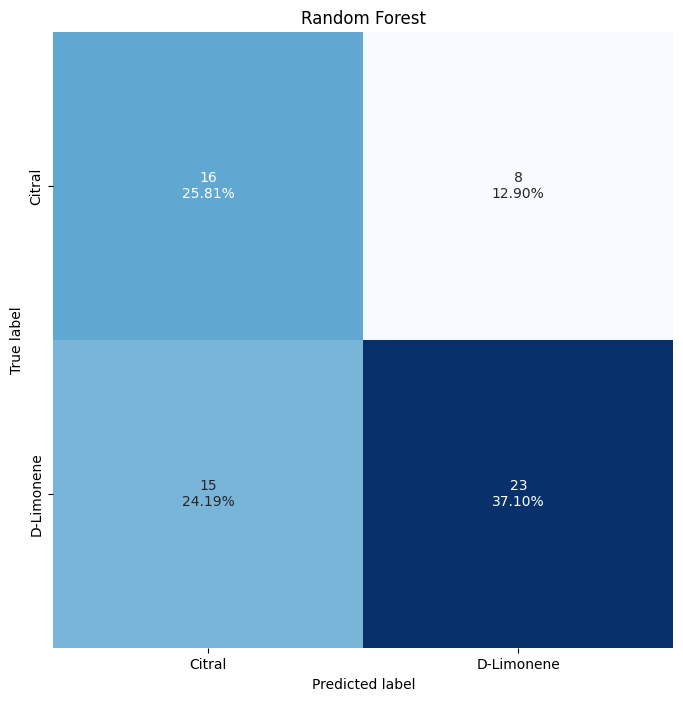

In [13]:
# random_forest_list = list(selected_feat)

print("\nRandom Forest\n")
rf_filtered = RandomForestClassifier(n_estimators = 200)
rf_filtered.fit(X_filtered_train_15, y_train)
print(classification_report(y_test, rf_filtered.predict(X_filtered_test_15)))
conf_mat = confusion_matrix(y_test, rf_filtered.predict(X_filtered_test_15))
make_confusion_matrix(conf_mat, figsize=(8,8), cbar=False, title="Random Forest", categories=categories, sum_stats=False)
print(conf_mat)


SVM

                   precision    recall  f1-score   support

    Citral200 mic       0.67      0.58      0.62        24
D-Limonene200 mic       0.76      0.82      0.78        38

         accuracy                           0.73        62
        macro avg       0.71      0.70      0.70        62
     weighted avg       0.72      0.73      0.72        62

[[14 10]
 [ 7 31]]


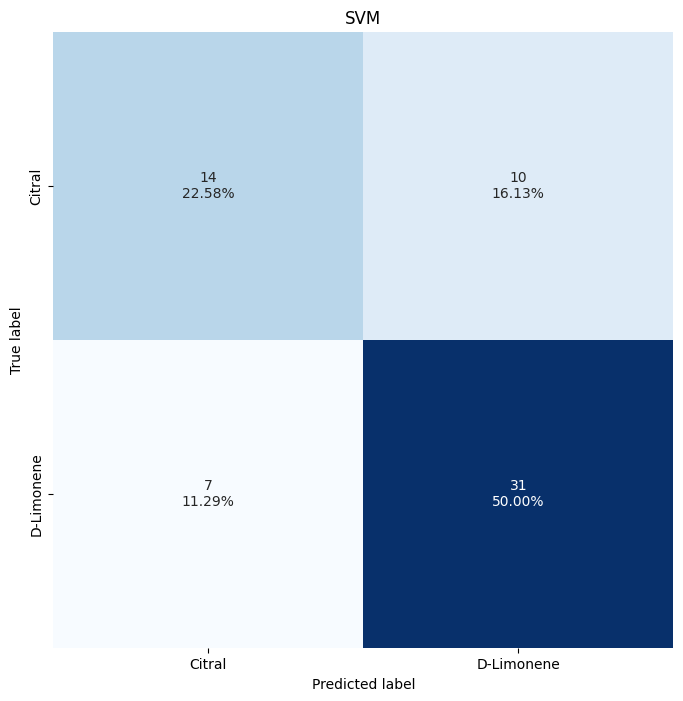

In [15]:

# SVM w/ Feature Selection

print("\nSVM\n")
clf = svm.SVC(kernel='linear')
clf.fit(X_filtered_train_scaled, y_train)
print(classification_report(y_test, clf.predict(X_filtered_test_scaled)))
conf_mat = confusion_matrix(y_test, clf.predict(X_filtered_test_scaled))
make_confusion_matrix(conf_mat, figsize=(8,8), cbar=False, title="SVM", categories=categories, sum_stats=False)
print(conf_mat)

In [14]:
# XGBoost w/ Feature Selection

y_test_xgb = y_test.replace( ['Citral200 mic', 'D-Limonene200 mic'], [0,1])
y_train_xgb = y_train.replace( ['Citral200 mic', 'D-Limonene200 mic'], [0,1])
sel = SelectFromModel(XGBClassifier(), max_features=15)
sel.fit(X_filtered_train, y_train_xgb)
selected_feat= X_filtered_train.columns[(sel.get_support())]
print(list(selected_feat))
X_filtered_train_15 = X_filtered_train[list(selected_feat)]
X_filtered_test_15 = X_filtered_test[list(selected_feat)]
# xgboost_list = list(selected_feat)

['value__skewness', 'value__longest_strike_above_mean', 'value__index_mass_quantile__q_0.1', 'value__index_mass_quantile__q_0.3', 'value__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'value__fft_coefficient__attr_"real"__coeff_6', 'value__fft_coefficient__attr_"abs"__coeff_40', 'value__fft_coefficient__attr_"abs"__coeff_42', 'value__fft_coefficient__attr_"angle"__coeff_4', 'value__fft_aggregated__aggtype_"skew"', 'value__approximate_entropy__m_2__r_0.9', 'value__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'value__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'value__permutation_entropy__dimension_4__tau_1']



XGBoost

              precision    recall  f1-score   support

           0       0.70      0.67      0.68        24
           1       0.79      0.82      0.81        38

    accuracy                           0.76        62
   macro avg       0.75      0.74      0.74        62
weighted avg       0.76      0.76      0.76        62

[[16  8]
 [ 7 31]]


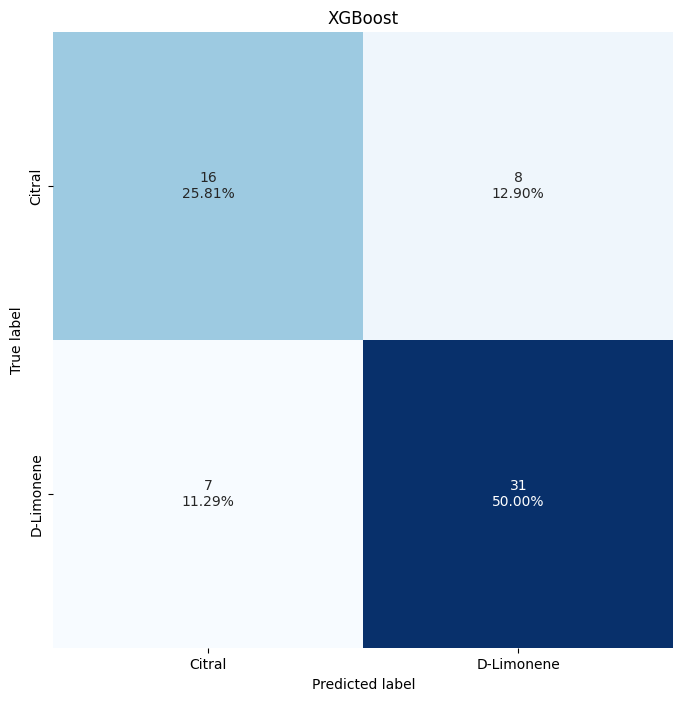

In [16]:
print("\nXGBoost\n")
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_filtered_train_15, y_train_xgb)
print(classification_report(y_test_xgb, xgb_classifier.predict(X_filtered_test_15)))
conf_mat = confusion_matrix(y_test_xgb, xgb_classifier.predict(X_filtered_test_15))
make_confusion_matrix(conf_mat, figsize=(8,8), cbar=False, title="XGBoost", categories=categories, sum_stats=False)
print(conf_mat)
# print(set(xgboost_list) & set(random_forest_list))


KNN

                   precision    recall  f1-score   support

    Citral200 mic       0.62      0.67      0.64        24
D-Limonene200 mic       0.78      0.74      0.76        38

         accuracy                           0.71        62
        macro avg       0.70      0.70      0.70        62
     weighted avg       0.71      0.71      0.71        62

[[16  8]
 [10 28]]


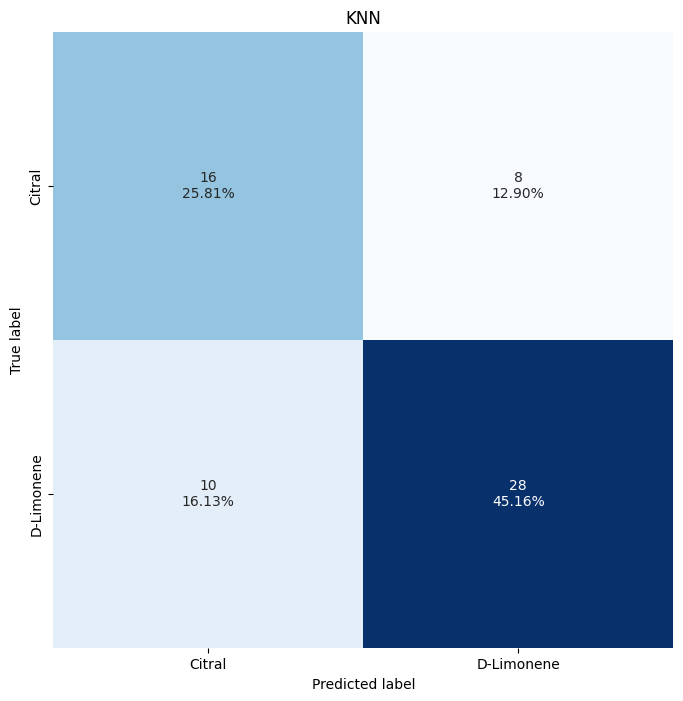

In [17]:
# KNN w/ Feature Selection

print("\nKNN\n")
knn_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_classifier.fit(X_filtered_train_scaled, y_train)
print(classification_report(y_test, knn_classifier.predict(X_filtered_test_scaled)))
conf_mat = confusion_matrix(y_test, knn_classifier.predict(X_filtered_test_scaled))
make_confusion_matrix(conf_mat, figsize=(8,8), cbar=False, title="KNN", categories=categories, sum_stats=False)
print(conf_mat)